In [1]:
#from prepare_dataset import CropTypesDataset
from data.russia import Russia
import datetime
import numpy as np
import os
import pandas as pd
import random
import torch

/home/pavel/.venv/hse/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
dataroot = os.path.join(os.environ["HOME"], "elects_data", "russia")

In [4]:
rd = Russia(root=dataroot,
           partition="train",
           sequencelength=5,
           year=2018,
           use_cache=True,
           return_id=True,
           broadcast_y=False)

Cache is activated and will be used if possible
Data: train, year: 2018
Trying to use cache
Loading X and y from cache
Russia dataset for 2018 year (train part) is loaded. It contains 8264 fields


In [12]:
X, y = rd["X"], rd["y"]

In [13]:
X.shape, y.shape

((8264, 50), (8264,))

In [4]:
BANDS = [
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B11",
    "B12",
]  # , 'NDVI'
TIME_INTERVAL = [(4, 1), (9, 30)]
region = "russia"
year = 2018
train_features_filepath = os.path.join(
    dataroot, f"{region}-{year}/train_features.csv.zip"
)
test_features_filepath = os.path.join(
    dataroot, f"{region}-{year}/test_features.csv.zip"
)
parcelsmapping_path = os.path.join(
    dataroot, f"{region}-{year}/parcelsmapping.csv"
)
classmapping_path = os.path.join(dataroot, "classmapping.csv")


def default_transform(x: np.ndarray, sequencelength: int) -> np.ndarray:
    # choose with replacement if sequencelength smaller als choose_t
    replace = False if x.shape[0] >= sequencelength else True
    idxs = np.random.choice(x.shape[0], sequencelength, replace=replace)
    idxs.sort()
    x = x[idxs]
    return x


cd = CropTypesDataset(
    features_filepath=train_features_filepath,
    classmapping_path=classmapping_path,
    fieldsmapping_path=parcelsmapping_path,
    bands=BANDS,
    time_interval=TIME_INTERVAL,
    sequencelength=5,
    transform=default_transform,
)

# Part 1: Classical Machine Learning

## Data preparation

In [13]:
train = pd.read_csv("/home/pavel/elects_data/russia/russia-2021/train_features.csv.zip")
test = pd.read_csv("/home/pavel/elects_data/russia/russia-2021/test_features.csv.zip")

In [40]:
train.shape, test.shape

((837200, 18), (217682, 18))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837200 entries, 0 to 837199
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   index                   837200 non-null  int64  
 1   timestamp               837200 non-null  object 
 2   field_id                837200 non-null  int64  
 3   eopatch                 837200 non-null  object 
 4   parcel_pixels           837200 non-null  int64  
 5   B02                     837200 non-null  float64
 6   B03                     837200 non-null  float64
 7   B04                     837200 non-null  float64
 8   B05                     837200 non-null  float64
 9   B06                     837200 non-null  float64
 10  B07                     837200 non-null  float64
 11  B08                     837200 non-null  float64
 12  B8A                     837200 non-null  float64
 13  B11                     837200 non-null  float64
 14  B12                 

In [9]:
train.head(10)

,index,field_id,eopatch,parcel_pixels,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,parcell_cloud_coverage,parcell_data_coverage,class_id
timestamp,,,,,,,,,,,,,,,,,
2021-04-01,0,2591,37UCS_2_1,856,440.0,389.0,437.5,470.0,475.0,509.0,561.0,565.0,988.0,793.5,0.450025,0.522777,0
2021-04-06,1,2591,37UCS_2_1,6151,211.0,277.0,402.0,474.0,511.0,567.0,656.0,689.0,1766.0,1633.0,0.000000,0.522777,0
2021-04-11,2,2591,37UCS_2_1,6151,297.0,323.0,457.0,517.0,563.0,630.0,749.0,767.0,1991.0,1913.0,0.000000,0.522777,0
2021-05-01,3,2591,37UCS_2_1,6151,471.0,484.0,600.0,694.0,774.0,865.0,983.0,1030.0,2411.0,2295.0,0.000000,0.522777,0
2021-05-16,4,2591,37UCS_2_1,5545,317.0,337.0,256.0,371.0,645.0,674.0,678.0,702.0,711.0,533.0,0.051504,0.522777,0
2021-06-10,5,2591,37UCS_2_1,5479,441.0,472.0,446.0,572.0,867.0,991.0,1040.0,1072.0,1511.0,1277.0,0.057114,0.522777,0
2021-06-15,6,2591,37UCS_2_1,6151,411.0,549.0,492.0,759.0,1429.0,1622.0,1654.0,1769.0,2433.0,1914.0,0.000000,0.522777,0
2021-06-20,7,2591,37UCS_2_1,6151,472.0,646.0,462.0,795.0,2233.0,2769.0,2812.0,2887.0,2232.0,1508.0,0.000000,0.522777,0
2021-06-25,8,2591,37UCS_2_1,6151,392.0,559.0,386.0,703.0,2304.0,3026.0,2952.0,3167.0,1998.0,1158.0,0.000000,0.522777,0


In [39]:
X_train = train\
    .pivot(
        index="field_id",
        columns="timestamp",
        values=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"])\
    .reset_index(drop=True)
X_train.columns = [f"{a}_{b}" for a, b in X_train.columns]
X_train.interpolate(method="linear", axis=1, inplace=True)
X_train = X_train.fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)

In [40]:
y_train = train.groupby("field_id").agg({"class_id": max})["class_id"]
y_train.shape, y.iloc[0:5]

((30417,),
 field_id
 2591    0
 2592    0
 2593    0
 2594    0
 2595    0
 Name: class_id, dtype: int64)

In [41]:
X_train.head()

,B02_2021-04-01,B02_2021-04-02,B02_2021-04-03,B02_2021-04-04,B02_2021-04-05,B02_2021-04-06,B02_2021-04-07,B02_2021-04-08,B02_2021-04-09,B02_2021-04-10,...,B12_2021-09-21,B12_2021-09-22,B12_2021-09-23,B12_2021-09-24,B12_2021-09-25,B12_2021-09-26,B12_2021-09-27,B12_2021-09-28,B12_2021-09-29,B12_2021-09-30
0,440.0,394.200000,348.400000,302.600000,256.800000,211.000000,228.200000,245.400000,262.60000,279.800000,...,2707.00000,2707.00000,2707.00000,2707.00000,2707.00000,2707.00000,2707.00000,2707.00000,2707.00000,2707.00000
1,576.0,507.200000,438.400000,369.600000,300.800000,232.000000,248.600000,265.200000,281.80000,298.400000,...,2676.00000,2676.00000,2676.00000,2676.00000,2676.00000,2676.00000,2676.00000,2676.00000,2676.00000,2676.00000
2,382.0,354.200000,326.400000,298.600000,270.800000,243.000000,269.400000,295.800000,322.20000,348.600000,...,2883.00000,2883.00000,2883.00000,2883.00000,2883.00000,2883.00000,2883.00000,2883.00000,2883.00000,2883.00000
3,1670.0,1385.969331,1101.938661,817.907992,533.877323,249.846653,263.136106,276.425558,289.71501,303.004462,...,2798.38986,2798.38986,2798.38986,2798.38986,2798.38986,2798.38986,2798.38986,2798.38986,2798.38986,2798.38986
4,195.0,195.000000,195.000000,195.000000,195.000000,195.000000,211.800000,228.600000,245.40000,262.200000,...,2854.00000,2854.00000,2854.00000,2854.00000,2854.00000,2854.00000,2854.00000,2854.00000,2854.00000,2854.00000


In [42]:
y_train

field_id
2591     0
2592     0
2593     0
2594     0
2595     0
        ..
82578    3
88485    3
88493    3
89284    3
89301    3
Name: class_id, Length: 30417, dtype: int64

In [53]:
X_test = test\
    .pivot(
        index="field_id",
        columns="timestamp",
        values=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"])\
    .reset_index(drop=True)
X_test.columns = [f"{a}_{b}" for a, b in X_test.columns]
X_test.interpolate(method="linear", axis=1, inplace=True)
X_test = X_test.fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)

In [54]:
y_test = train.groupby("field_id").agg({"class_id": max})["class_id"]
y_test.shape, y.iloc[0:5]

((30417,),
 field_id
 2591    0
 2592    0
 2593    0
 2594    0
 2595    0
 Name: class_id, dtype: int64)

## Model Training and Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

### Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [46]:
rfc = RandomForestClassifier()

gs_params = {
    "n_estimators": range(10, 110, 30),
    "max_depth": range(3, 11, 3),
    "min_samples_split": range(5, 26, 10)
}

gs1 = GridSearchCV(rfc, gs_params, scoring="accuracy", n_jobs=1, verbose=2, cv=3)
gs1.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ..max_depth=3, min_samples_split=5, n_estimators=10; total time=   3.1s
[CV] END ..max_depth=3, min_samples_split=5, n_estimators=10; total time=   3.1s
[CV] END ..max_depth=3, min_samples_split=5, n_estimators=10; total time=   3.2s
[CV] END ..max_depth=3, min_samples_split=5, n_estimators=40; total time=  12.0s
[CV] END ..max_depth=3, min_samples_split=5, n_estimators=40; total time=  12.0s
[CV] END ..max_depth=3, min_samples_split=5, n_estimators=40; total time=  12.3s
[CV] END ..max_depth=3, min_samples_split=5, n_estimators=70; total time=  21.2s
[CV] END ..max_depth=3, min_samples_split=5, n_estimators=70; total time=  20.5s
[CV] END ..max_depth=3, min_samples_split=5, n_estimators=70; total time=  21.5s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=100; total time=  30.0s
[CV] END .max_depth=3, min_samples_split=5, n_estimators=100; total time=  29.6s
[CV] END .max_depth=3, min_samples_split=5, n_e

[CV] END .max_depth=9, min_samples_split=25, n_estimators=40; total time=  32.0s
[CV] END .max_depth=9, min_samples_split=25, n_estimators=70; total time=  54.1s
[CV] END .max_depth=9, min_samples_split=25, n_estimators=70; total time=  54.2s
[CV] END .max_depth=9, min_samples_split=25, n_estimators=70; total time=  54.9s
[CV] END max_depth=9, min_samples_split=25, n_estimators=100; total time= 1.3min
[CV] END max_depth=9, min_samples_split=25, n_estimators=100; total time= 1.3min
[CV] END max_depth=9, min_samples_split=25, n_estimators=100; total time= 1.3min


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': range(3, 11, 3),
                         'min_samples_split': range(5, 26, 10),
                         'n_estimators': range(10, 110, 30)},
             scoring='accuracy', verbose=2)

In [51]:
gs1.best_score_, gs1.best_estimator_

(0.7124963014103954, RandomForestClassifier(max_depth=9, min_samples_split=25))

In [55]:
y_pred = gs1.predict(X_test)
accuracy_score(y_test,y_pred), f1_score(y_test,y_pred)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- B02_2021-09-24
- B03_2021-09-24
- B04_2021-09-24
- B05_2021-09-24
- B06_2021-09-24
- ...


In [25]:
from dataclasses import dataclass
import pandas as pd
import os
import torch
from train import train

In [6]:
@dataclass
class TrainConfig:
    dataset: str = "russia"
    alpha: float = 0.5
    epsilon: float = 10
    learning_rate: float = 10e-3
    weight_decay: float = 0
    patience: int = 30
    device: str = "cuda" if torch.cuda.is_available() else "cpu"               
    epochs: int = 50
    sequencelength: int = 183
    batchsize: int = 128
    dataroot: str = os.path.join(os.environ["HOME"],"elects_data")
    snapshot: str = "snapshots/model.pth"
    resume: bool = False
    year: int = 2021
    use_cache: bool = True
    model: str = "earlyrnn"
    n_months: int = 6
    visualize: bool = False
    hyperparameters: dict = None    

In [8]:
rf_stats = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(model="rf",
                       n_months=n_months,
                       sequencelength=sequencelength,
                       hyperparameters={"n_estimators": range(10, 110, 20)})
    best_model, train_stats = train(args)
    rf_stats.append(train_stats)

Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
X shape: (30417, 100) y shape: (30417,)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Cache is activated and will be used if possible
Data: train, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (train part) is loaded. It contains 30417 fields
Cache is activated and will be used if possible
Data: test, year: 2021
Trying to use cache
Loading X and y from cache
Russia dataset for 2021 year (test part) is loaded. It contains 7595 fields
X shape: (30417, 200) y shape: (30417,)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Cache is activated

In [21]:
rf_dfs = []
for i, stat in enumerate(rf_stats):
    df = pd.DataFrame(stat)
    df["n_months"] = i + 1
    rf_dfs.append(df)
rf_stat_df = pd.concat(rf_dfs)
rf_stat_df.reset_index(drop=True, inplace=True)

In [22]:
rf_stat_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,rank_test_fscore,split0_test_kappa,split1_test_kappa,split2_test_kappa,split3_test_kappa,split4_test_kappa,mean_test_kappa,std_test_kappa,rank_test_kappa,n_months
0,5.530161,0.536271,0.053766,0.004011,10,{'n_estimators': 10},0.516437,0.533531,0.535427,0.518823,...,5,0.434456,0.455954,0.453075,0.434335,0.443335,0.444231,0.009055,5,1
1,17.307498,1.239440,0.121411,0.007994,30,{'n_estimators': 30},0.567061,0.583333,0.579813,0.565839,...,4,0.492100,0.512435,0.503674,0.487696,0.503190,0.499819,0.008854,4,1
2,26.955016,3.128957,0.178361,0.025497,50,{'n_estimators': 50},0.583498,0.592045,0.590334,0.586060,...,3,0.511208,0.522253,0.516077,0.511640,0.523168,0.516869,0.005073,3,1
3,40.585612,4.652533,0.208319,0.021689,70,{'n_estimators': 70},0.588264,0.600756,0.601184,0.589347,...,1,0.516186,0.532388,0.528745,0.515077,0.527616,0.524002,0.007023,1,1
4,41.468254,6.151401,0.256024,0.032987,90,{'n_estimators': 90},0.592373,0.597962,0.597238,0.591156,...,2,0.521004,0.528986,0.523690,0.516920,0.523799,0.522880,0.003946,2,1
5,7.078377,0.816084,0.051993,0.006682,10,{'n_estimators': 10},0.575937,0.587114,0.592964,0.585566,...,5,0.505767,0.519083,0.522750,0.513864,0.512201,0.514733,0.005844,5,2
6,21.323907,2.623709,0.109219,0.013138,30,{'n_estimators': 30},0.617357,0.625904,0.639816,0.626336,...,4,0.552271,0.562799,0.576646,0.560217,0.554982,0.561383,0.008489,4,2
7,36.277406,4.429330,0.164226,0.016719,50,{'n_estimators': 50},0.634287,0.647272,0.648529,0.646227,...,3,0.571806,0.587935,0.586828,0.583978,0.572795,0.580668,0.006961,3,2
8,49.724756,6.115824,0.229821,0.019663,70,{'n_estimators': 70},0.636259,0.648751,0.652474,0.650337,...,2,0.574069,0.589371,0.591202,0.588727,0.578045,0.584283,0.006881,2,2
9,60.738212,8.817731,0.249882,0.025376,90,{'n_estimators': 90},0.645135,0.644806,0.655104,0.652310,...,1,0.584666,0.584755,0.594411,0.590973,0.578874,0.586736,0.005420,1,2


<AxesSubplot: xlabel='n_months'>

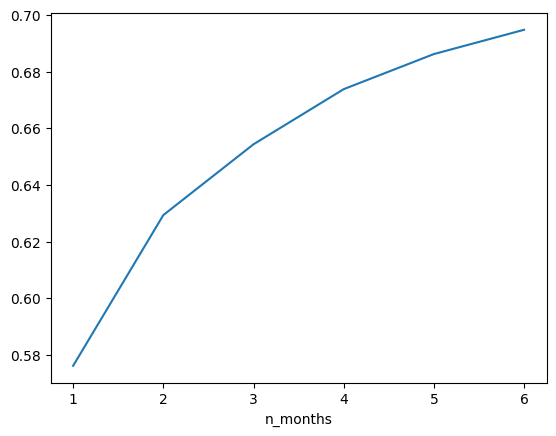

In [24]:
rf_stat_df.groupby("n_months")["mean_test_accuracy"].mean().plot()

In [8]:
lgbm_stats = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(model="lightgbm",
                       n_months=n_months,
                       sequencelength=sequencelength,
                       hyperparameters={"n_estimators": range(10, 110, 20)})
    best_model, train_stats = train(args)
    lgbm_stats.append(train_stats)

In [ ]:
xgb_stats = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(model="xgboost",
                       n_months=n_months,
                       sequencelength=sequencelength,
                       hyperparameters={"n_estimators": range(10, 110, 20)})
    best_model, train_stats = train(args)
    xgb_stats.append(train_stats)

In [ ]:
transformer_stats = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(epochs=50,
                       model="transformer",
                       n_months=n_months,
                       sequencelength=sequencelength)
    best_model, train_stats = train(args)
    transformer_stats.append(train_stats)

In [ ]:
tempcnn_stats = []
for n_months, sequencelength in zip(range(1, 7), range(10, 70, 10)):
    args = TrainConfig(epochs=50,
                       model="tempcnn",
                       n_months=n_months,
                       sequencelength=sequencelength)
    best_model, train_stats = train(args)
    tempcnn_stats.append(train_stats)